In [2]:
import numpy as np
import pandas as pd
import sys
sys.path.append('../')
from utils import quantize_data, mu_law_encoding, mu_law_expansion, butter_lowpass_filter
from torch.utils.data import Dataset, DataLoader
import torch
import torch_audiomentations as tA


In [39]:
raw_eggs = np.load('../data/eegs.npy', allow_pickle=True)
raw_eggs = raw_eggs.view().item()
print(raw_eggs[568657].shape)
raw_eggs

(10000, 8)


{568657: array([[  26.13999939,  149.5       ,  114.16000366, ...,   21.82999992,
          241.25      ,  150.97999573],
        [  -0.86000001,  119.04000092,   94.05000305, ...,   -3.0999999 ,
          225.08999634,  126.43000031],
        [   6.09000015,  109.25      ,   73.16000366, ...,   -6.84000015,
          196.69999695,  120.34999847],
        ...,
        [ -79.41000366,  -22.36000061,  154.63999939, ...,  -44.34999847,
          114.37999725,  -49.04999924],
        [-109.79000092,  -59.08000183,  136.36000061, ...,  -83.83000183,
           79.72000122,  -84.27999878],
        [-127.66000366,  -96.01999664,   98.91999817, ..., -118.90000153,
           15.35000038, -124.69000244]])}

In [46]:
class CustomDataset1D(Dataset):
    def __init__(self, eegs=None, augmentations = None, test = False) -> None:
        super().__init__()
        self.eegs = eegs
        self.augmentations = augmentations
        #self.label_cols = ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']
    
    def __len__(self):
        return 1
    
    def __getitem__(self, index):
        data = self.eegs[568657]
        data = np.clip(data,-1024,1024)
        data = np.nan_to_num(data, nan=0) / 32.0
        
        data = butter_lowpass_filter(data)
        data = quantize_data(data,1)

        samples = torch.from_numpy(data).float()
        
        #samples = self.__transform(samples.unsqueeze(0))
        #samples = samples.squeeze()

        samples = samples.permute(1,0)
        
        return samples
    
    def __transform(self):
        if self.augmentations:
            return tA.Compose(
                transforms=[
                    # tA.ShuffleChannels(p=0.25,mode="per_channel",p_mode="per_channel",),
                    tA.AddColoredNoise(p=0.15,mode="per_channel",p_mode="per_channel", max_snr_in_db = 15, sample_rate=200),
                ])
        return tA.Compose([])

In [47]:
ds = CustomDataset1D(eegs=raw_eggs)
dl = DataLoader(ds, batch_size=1, shuffle=True)

In [50]:
for i in ds:
    print(i.shape)
    print(i)
    break

torch.Size([8, 10000])
tensor([[ 0.0057,  0.0356,  0.1031,  ..., -1.5441, -1.7413, -1.8865],
        [ 0.0322,  0.2160,  0.6360,  ..., -0.6047, -0.7651, -0.9236],
        [ 0.0246,  0.1684,  0.5105,  ...,  2.5807,  2.5334,  2.4810],
        ...,
        [ 0.0047,  0.0293,  0.0811,  ..., -0.8439, -1.1285, -1.3561],
        [ 0.0515,  0.3398,  0.9477,  ...,  2.5063,  2.3983,  2.2700],
        [ 0.0325,  0.2191,  0.6480,  ..., -1.3970, -1.4702, -1.5430]])


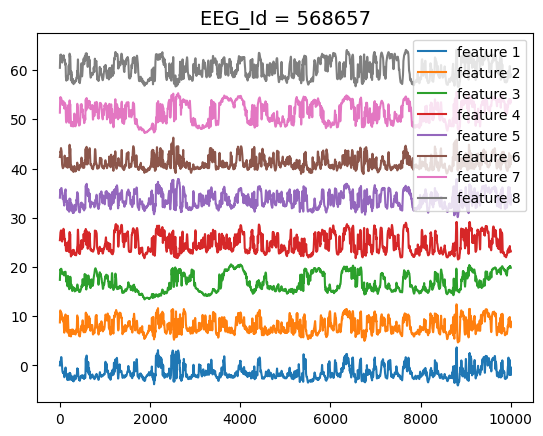

In [62]:
import matplotlib.pyplot as plt
img = ds[0].detach().numpy()
img = img.transpose(1,0) #10000*8
offset = 0
for j in range(img.shape[-1]):
    if j != 0: 
        offset -= img[:, j].min()
    plt.plot(img[:, j] + offset, label=f'feature {j+1}')
    offset += img[:, j].max() + 1  # Adding 1 for visual separation

plt.legend()
plt.title(f'EEG_Id = {568657}', size=14)
plt.show()


In [1]:
import pandas as pd
data = pd.read_parquet('../data/1000086677.parquet')
print(data.shape)
data

(300, 401)


,time,LL_0.59,LL_0.78,LL_0.98,LL_1.17,LL_1.37,LL_1.56,LL_1.76,LL_1.95,LL_2.15,...,RP_18.16,RP_18.36,RP_18.55,RP_18.75,RP_18.95,RP_19.14,RP_19.34,RP_19.53,RP_19.73,RP_19.92
0,1,28.680000,53.990002,67.629997,59.880001,50.880001,74.309998,78.480003,63.080002,59.869999,...,0.13,0.14,0.08,0.11,0.04,0.03,0.05,0.05,0.04,0.05
1,3,29.639999,38.959999,44.009998,66.800003,48.509998,42.180000,47.340000,48.599998,40.880001,...,0.15,0.13,0.08,0.08,0.07,0.06,0.07,0.06,0.06,0.06
2,5,8.890000,9.020000,16.360001,23.559999,27.340000,30.040001,27.559999,23.290001,15.120000,...,0.12,0.11,0.08,0.08,0.09,0.10,0.12,0.14,0.13,0.14
3,7,1.770000,1.930000,1.810000,1.600000,1.430000,1.280000,1.190000,1.110000,1.010000,...,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.04,0.04,0.04
4,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,591,2.210000,2.280000,2.200000,1.280000,1.350000,1.930000,2.300000,2.440000,2.310000,...,0.03,0.03,0.03,0.03,0.03,0.04,0.04,0.03,0.03,0.03
296,593,2.490000,2.540000,2.150000,1.490000,1.360000,1.570000,1.970000,2.050000,1.890000,...,0.02,0.02,0.02,0.03,0.02,0.02,0.02,0.01,0.01,0.01
297,595,0.240000,0.190000,0.210000,0.120000,0.110000,0.080000,0.060000,0.040000,0.040000,...,0.00,0.00,0.00,0.01,0.01,0.01,0.01,0.00,0.00,0.00
298,597,0.990000,1.230000,1.370000,1.620000,1.940000,2.190000,2.270000,2.310000,2.300000,...,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.01,0.01,0.01


In [3]:
data.iloc[:, 1:]

,LL_0.59,LL_0.78,LL_0.98,LL_1.17,LL_1.37,LL_1.56,LL_1.76,LL_1.95,LL_2.15,LL_2.34,...,RP_18.16,RP_18.36,RP_18.55,RP_18.75,RP_18.95,RP_19.14,RP_19.34,RP_19.53,RP_19.73,RP_19.92
0,28.680000,53.990002,67.629997,59.880001,50.880001,74.309998,78.480003,63.080002,59.869999,62.939999,...,0.13,0.14,0.08,0.11,0.04,0.03,0.05,0.05,0.04,0.05
1,29.639999,38.959999,44.009998,66.800003,48.509998,42.180000,47.340000,48.599998,40.880001,27.930000,...,0.15,0.13,0.08,0.08,0.07,0.06,0.07,0.06,0.06,0.06
2,8.890000,9.020000,16.360001,23.559999,27.340000,30.040001,27.559999,23.290001,15.120000,13.530000,...,0.12,0.11,0.08,0.08,0.09,0.10,0.12,0.14,0.13,0.14
3,1.770000,1.930000,1.810000,1.600000,1.430000,1.280000,1.190000,1.110000,1.010000,0.900000,...,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.04,0.04,0.04
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,2.210000,2.280000,2.200000,1.280000,1.350000,1.930000,2.300000,2.440000,2.310000,2.060000,...,0.03,0.03,0.03,0.03,0.03,0.04,0.04,0.03,0.03,0.03
296,2.490000,2.540000,2.150000,1.490000,1.360000,1.570000,1.970000,2.050000,1.890000,1.470000,...,0.02,0.02,0.02,0.03,0.02,0.02,0.02,0.01,0.01,0.01
297,0.240000,0.190000,0.210000,0.120000,0.110000,0.080000,0.060000,0.040000,0.040000,0.040000,...,0.00,0.00,0.00,0.01,0.01,0.01,0.01,0.00,0.00,0.00
298,0.990000,1.230000,1.370000,1.620000,1.940000,2.190000,2.270000,2.310000,2.300000,2.280000,...,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.01,0.01,0.01


In [4]:
import albumentations as A
